In [2]:
import xgboost as xgb 
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split
import warnings
import pandas as pd
warnings.filterwarnings('ignore')

df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_target = df['SUBCLASS']

data = df.drop(columns=['ID', 'SUBCLASS'])
df_test.drop(columns=['ID'], inplace=True)
data

In [3]:
disease_list = df.SUBCLASS.unique()
disease_list

array(['KIPAN', 'SARC', 'SKCM', 'KIRC', 'GBMLGG', 'STES', 'BRCA', 'THCA',
       'LIHC', 'HNSC', 'PAAD', 'OV', 'PRAD', 'UCEC', 'LAML', 'COAD',
       'ACC', 'LGG', 'LUSC', 'LUAD', 'CESC', 'PCPG', 'THYM', 'BLCA',
       'TGCT', 'DLBC'], dtype=object)

In [4]:
df[df.SUBCLASS=='ACC']

,ID,SUBCLASS,A2M,AAAS,AADAT,AARS1,ABAT,ABCA1,ABCA2,ABCA3,...,ZNF292,ZNF365,ZNF639,ZNF707,ZNFX1,ZNRF4,ZPBP,ZW10,ZWINT,ZYX
30,TRAIN_0030,ACC,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
44,TRAIN_0044,ACC,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
50,TRAIN_0050,ACC,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
183,TRAIN_0183,ACC,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
656,TRAIN_0656,ACC,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5901,TRAIN_5901,ACC,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
5917,TRAIN_5917,ACC,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
6035,TRAIN_6035,ACC,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
6082,TRAIN_6082,ACC,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT


In [6]:
def seek1():
    count_df = df[df.SUBCLASS=='ACC'].apply(lambda x : x!='WT').agg(sum).reset_index(name='count')
    gene_list = count_df[count_df['count']>0]['index'].values
    print(len(gene_list))

In [7]:
df[df.SUBCLASS=='SKCM'].apply(lambda x : x!='WT').columns


Index(['ID', 'SUBCLASS', 'A2M', 'AAAS', 'AADAT', 'AARS1', 'ABAT', 'ABCA1',
       'ABCA2', 'ABCA3',
       ...
       'ZNF292', 'ZNF365', 'ZNF639', 'ZNF707', 'ZNFX1', 'ZNRF4', 'ZPBP',
       'ZW10', 'ZWINT', 'ZYX'],
      dtype='object', length=4386)

In [8]:
def get_gene_list2():
    genes = []
    gene_set = set()
    for disease in df["SUBCLASS"].unique():
        disease_df = df[df["SUBCLASS"] == disease]

        non_wt_counts = (disease_df != 'WT').sum()  # "WT"가 아닌 행 개수
        non_wt_counts_sorted = non_wt_counts.sort_values(ascending=False) #빈도 수가 높은 순서대로 정렬

        n = 20 # 추출한 상위 유전자 개수
        genes.extend(list(non_wt_counts_sorted[2:2+n].index))

        #print(f'{disease} - 전체 행의 개수 : {len(disease_df)}')
        dd = non_wt_counts_sorted[2:n].reset_index()
        gene_list1 = dd['index'].values
        gene_set.update(gene_list1)
        #print(gene_list1)
    return gene_set

1. 처음에는 각 질병(암)마다 WT이 아닌(유전체 암 발현된)개수 5개 이상인 유전체들을 1차로 수집하고,
2. 암별로 transaction의 개수와 발현된 유전체 개수의 불균형이 심하고, 암마다 유의미한 유전체의 개수가 천차만별이라,
각 암 별로 의미있는 유전체의 개수를 공동발현한 유전체들을 추출하기 위해 상관관계 상위 >0.5로 다시 뽑는다. 
3.이 유전체 SET을 기반으로 DataFrame을 새로 만들고, 각 질병별 선정된 유전체들 외의 유전체들 값들을 WT처럼 0으로 cleansing(noise 제거)처리하고,
4. XGBoost, RF, 등으로 학습 후 결과를 도출해본다.


In [9]:
def get_gene_list1():
    selected_genes = set()
    for d in disease_list:
        count_df = df[df.SUBCLASS==d].apply(lambda x : x!='WT').agg(sum)
        count_df = count_df[2:].reset_index(name='count')        
        gene_list = count_df[count_df['count']>5]['index'].values
        print(d, len(gene_list))
        selected_genes.update(gene_list)
    print(len(selected_genes))
    return selected_genes
glist = get_gene_list1()

KIPAN 286
SARC 31
SKCM 2112
KIRC 68
GBMLGG 147
STES 2034
BRCA 691
THCA 4
LIHC 106
HNSC 334
PAAD 22
OV 47
PRAD 16
UCEC 2006
LAML 9
COAD 936
ACC 51
LGG 16
LUSC 587
LUAD 468
CESC 175
PCPG 3
THYM 1
BLCA 209
TGCT 14
DLBC 17
2925


In [21]:
from collections import defaultdict
import numpy as np
main_genes = defaultdict()
def get_gene_dictionary():
    for d in disease_list:
        count_df = df[df.SUBCLASS==d].apply(lambda x : x!='WT').agg(sum)
        count_df = count_df[2:].reset_index(name='count')        
        gene_list = count_df[count_df['count']>6]['index'].values
        main_genes[d]= gene_list
    return main_genes
#main_genes = get_gene_dictionary()

def extract_th(cancer_name):
    each_glist = main_genes.get(cancer_name)
    raw = df.copy() #pd.concat([data, df_test])
    gframe = raw.loc[:, each_glist]
    
    for c in gframe.columns:
        gframe[c] = gframe[c].apply(lambda x : 0 if x =='WT' else len(str(x).split(' ')))
    corr_matrix = gframe.corr().abs()
    sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
            .stack()
            .sort_values(ascending=False))
    aa = sol.reset_index()
    aa.columns =['level0','level1','rate']
    #print(aa)
    set1 = aa[aa.rate >= 0.5]['level0'].drop_duplicates()
    set2 = aa[aa.rate >= 0.5]['level1'].drop_duplicates()
    
    a1 = set() 
    a1.update(set1)
    a1.update(set2)
    #print(len(a1))
    
    return a1
    #df[df.SUBCLASS=='BRCA']['ABCA4'].apply(lambda x : 1 if x !='WT' else 0).sum()



In [22]:
main_genes = get_gene_dictionary()

In [23]:
for k, v in main_genes.items():
    print(k, len(v))
    #extract_genes = extract_th(k)
    #print(len(extract_genes))

KIPAN 194
SARC 22
SKCM 1844
KIRC 38
GBMLGG 107
STES 1686
BRCA 487
THCA 3
LIHC 65
HNSC 236
PAAD 15
OV 29
PRAD 11
UCEC 1633
LAML 7
COAD 715
ACC 38
LGG 12
LUSC 434
LUAD 358
CESC 121
PCPG 3
THYM 1
BLCA 132
TGCT 8
DLBC 11


In [24]:
for k, v in main_genes.items():
    print(k, len(v))    
    lena = len(v)
    if lena > 15:
        main_genes[k] = extract_th(k)
        print(len(main_genes[k]))
    #cleansing
        
    #extract_genes = extract_th(k)
    #print(len(extract_genes))

KIPAN 194
106
SARC 22
17
SKCM 1844
728
KIRC 38
27
GBMLGG 107
83
STES 1686
569
BRCA 487
265
THCA 3
LIHC 65
50
HNSC 236
149
PAAD 15
OV 29
24
PRAD 11
UCEC 1633
565
LAML 7
COAD 715
354
ACC 38
6
LGG 12
LUSC 434
266
LUAD 358
242
CESC 121
78
PCPG 3
THYM 1
BLCA 132
84
TGCT 8
DLBC 11


In [1]:
#cleansing
total = pd.concat([df, df_test])
total


NameError: name 'pd' is not defined

In [18]:
extract_genes = extract_th('BRCA')
print(len(extract_genes))

          level0    level1      rate
0         COL5A3    SCN10A  0.859155
1           RYR1    SCN10A  0.851417
2         COL5A3      RYR1  0.850204
3         COL5A3      SPTB  0.845100
4           NOS1      RYR1  0.839184
...          ...       ...       ...
118336      AGO2  HLA-DRB1  0.000459
118337       CAD  HLA-DRB1  0.000319
118338       BAX      GRM8  0.000091
118339     HLA-C      JAK1  0.000011
118340  HLA-DRB1     NLGN3  0.000008

[118341 rows x 3 columns]
265
265


In [19]:
extract_genes = extract_th('KIPAN')
print(len(extract_genes))

      level0  level1      rate
0       RYR1  SCN10A  0.851417
1       NOS1    RYR1  0.839184
2        LCT    RYR1  0.831768
3        LCT    NOS1  0.831723
4      KALRN    RYR1  0.830331
...      ...     ...       ...
18716   TNS1     VHL  0.000313
18717     F5     VHL  0.000220
18718  HLA-C   KDM6B  0.000213
18719  HLA-A     VHL  0.000112
18720     TG     VHL  0.000096

[18721 rows x 3 columns]
106
106


In [43]:
total = pd.concat([data, df_test])
#total = total.loc[:, list(glist)]
total = total.loc[:, main_genes.get('KIPAN')]
total

,ABCA1,ABCA4,ABCC3,ABL1,ACE,ADAR,ADCY9,AGL,AGRN,AHNAK,...,TP53,TRIO,TRO,TSC2,TUBGCP6,VCAN,VHL,VWF,WWP1,ZNFX1
0,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
1,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,M237I,WT,WT,K1585M,WT,WT,WT,WT,WT,WT
2,WT,WT,WT,I489I,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,R698K,WT,WT
3,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
4,WT,WT,WT,WT,WT,WT,WT,WT,WT,E1479V,...,M246R,WT,WT,WT,WT,WT,WT,WT,WT,WT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2541,WT,WT,WT,WT,WT,WT,WT,WT,WT,K884K,...,R114S R234S R141S R273S,WT,WT,WT,WT,WT,WT,WT,WT,WT
2542,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,R248W,WT,WT,WT,WT,WT,WT,WT,WT,WT
2543,L217I,G606D,A403A,S1106N S1125N,L696P L1270P L1081P L655P L986P L475P,WT,WT,R1121K R1105K,R1246Q,G2016C,...,WT,V1917M,G1300S G903S G831S,D1691E D1631E D1678E D1668E D1711E D1490E D168...,T1301M,T1553T T566T T3307T T2320T,WT,C898C,V72G,L305L
2544,WT,R1517H,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT


In [63]:
total = pd.concat([data, df_test])
#total = total.loc[:, list(glist)]
brca = total.loc[:, main_genes.get('BRCA')]
ccdf = brca.copy()
for c in ccdf.columns:
    ccdf[c] = ccdf[c].apply(lambda x : 0 if x =='WT' else len(str(x).split(' ')))
ccdf

,A2M,ABAT,ABCA1,ABCA3,ABCA4,ABCA5,ABCA6,ABCA8,ABCA9,ABCB1,...,VWF,WDR33,WLS,WNT7A,WRN,XPO1,ZEB1,ZFPM2,ZNF292,ZNFX1
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2541,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2542,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2543,0,0,1,1,1,1,1,5,1,0,...,1,1,0,0,1,0,12,3,2,1
2544,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
ccdf = total.copy()
for c in ccdf.columns:
    ccdf[c] = ccdf[c].apply(lambda x : 0 if x =='WT' else len(str(x).split(' ')))
ccdf


,A2M,AAAS,AADAT,AARS1,ABAT,ABCA1,ABCA2,ABCA3,ABCA4,ABCA5,...,ZNF292,ZNF365,ZNF639,ZNF707,ZNFX1,ZNRF4,ZPBP,ZW10,ZWINT,ZYX
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2541,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2542,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2543,0,0,0,0,0,1,2,1,1,1,...,2,1,0,0,1,0,2,1,0,0
2544,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [58]:
ccdf.corr().reset_index()

,index,ABCA1,ABCA4,ABCC3,ABL1,ACE,ADAR,ADCY9,AGL,AGRN,...,TP53,TRIO,TRO,TSC2,TUBGCP6,VCAN,VHL,VWF,WWP1,ZNFX1
0,ABCA1,1.000000,0.306810,0.211538,0.225938,0.208339,0.210263,0.301271,0.298447,0.218490,...,0.053592,0.323630,0.256348,0.153073,0.239479,0.411890,0.004739,0.309218,0.258717,0.303444
1,ABCA4,0.306810,1.000000,0.612657,0.275946,0.413745,0.196051,0.215207,0.274266,0.247571,...,0.064327,0.523503,0.318844,0.157951,0.357421,0.582219,0.007549,0.617522,0.296622,0.375427
2,ABCC3,0.211538,0.612657,1.000000,0.275995,0.418151,0.167187,0.200698,0.243444,0.230760,...,0.040666,0.459976,0.270010,0.156606,0.334227,0.509470,-0.001175,0.590558,0.261597,0.294917
3,ABL1,0.225938,0.275946,0.275995,1.000000,0.280598,0.250384,0.220165,0.284564,0.229859,...,0.069673,0.291748,0.298985,0.251475,0.232566,0.322632,0.034138,0.277561,0.236823,0.228379
4,ACE,0.208339,0.413745,0.418151,0.280598,1.000000,0.240670,0.177322,0.330939,0.277809,...,0.076490,0.364602,0.293658,0.207783,0.293884,0.397280,0.050059,0.395464,0.197858,0.272975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,VCAN,0.411890,0.582219,0.509470,0.322632,0.397280,0.308376,0.314014,0.383967,0.282327,...,0.106590,0.543501,0.399404,0.208390,0.394026,1.000000,0.001593,0.561915,0.362543,0.441830
190,VHL,0.004739,0.007549,-0.001175,0.034138,0.050059,0.025984,0.032687,0.026059,0.020842,...,-0.081389,0.002106,0.018939,0.027676,-0.005026,0.001593,1.000000,0.015411,0.024871,0.019395
191,VWF,0.309218,0.617522,0.590558,0.277561,0.395464,0.198709,0.196208,0.277519,0.235676,...,0.069898,0.501255,0.285019,0.122003,0.351557,0.561915,0.015411,1.000000,0.292647,0.342594
192,WWP1,0.258717,0.296622,0.261597,0.236823,0.197858,0.211448,0.326038,0.288459,0.180668,...,0.036015,0.287818,0.232938,0.181074,0.198257,0.362543,0.024871,0.292647,1.000000,0.317211


In [69]:
import numpy as np
corr_matrix = ccdf.corr().abs()

sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
                  .stack()
                  .sort_values(ascending=False))

In [87]:
sol

COL5A3  RYR1        0.796926
        SPTB        0.789590
        SCN10A      0.789522
        LCT         0.781950
LCT     RYR1        0.779663
                      ...   
OCRL    TP53        0.001265
ABCF2   MAML2       0.001094
        MADD        0.000724
        ERBB2       0.000117
ETS1    HLA-DRB1    0.000025
Length: 118341, dtype: float64

In [88]:
sol.C3

RYR1        0.777795
COL5A3      0.773669
LCT         0.761156
DSC2        0.751010
SCN10A      0.746002
              ...   
SMAD2       0.068121
MYB         0.065808
TP53        0.053053
RUNX1       0.044015
HLA-DRB1    0.037548
Length: 415, dtype: float64

In [89]:
sol.MYB

SORBS2    0.337730
SPTAN1    0.327163
SCAF8     0.309080
PLK2      0.249521
TNRC6B    0.246868
            ...   
PCLO      0.052476
SPTB      0.051271
SIDT2     0.049320
TP53      0.043066
SMAD2     0.025505
Length: 204, dtype: float64

In [91]:
sol.reset_index()

,level_0,level_1,0
0,COL5A3,RYR1,0.796926
1,COL5A3,SPTB,0.789590
2,COL5A3,SCN10A,0.789522
3,COL5A3,LCT,0.781950
4,LCT,RYR1,0.779663
...,...,...,...
118336,OCRL,TP53,0.001265
118337,ABCF2,MAML2,0.001094
118338,ABCF2,MADD,0.000724
118339,ABCF2,ERBB2,0.000117


In [94]:
aa =sol.reset_index()
aa.columns =['level0','level1','rate']
aa

,level0,level1,rate
0,COL5A3,RYR1,0.796926
1,COL5A3,SPTB,0.789590
2,COL5A3,SCN10A,0.789522
3,COL5A3,LCT,0.781950
4,LCT,RYR1,0.779663
...,...,...,...
118336,OCRL,TP53,0.001265
118337,ABCF2,MAML2,0.001094
118338,ABCF2,MADD,0.000724
118339,ABCF2,ERBB2,0.000117


In [98]:
set1 = aa[aa.rate >= 0.5]['level0'].drop_duplicates()
set2 = aa[aa.rate >= 0.5]['level1'].drop_duplicates()
a1 = set() 
a1.update(set1)
a1.update(set2)
len(a1)



159

In [110]:
df[df.SUBCLASS=='BRCA']['ABCA4'].apply(lambda x : 1 if x !='WT' else 0).sum()

15

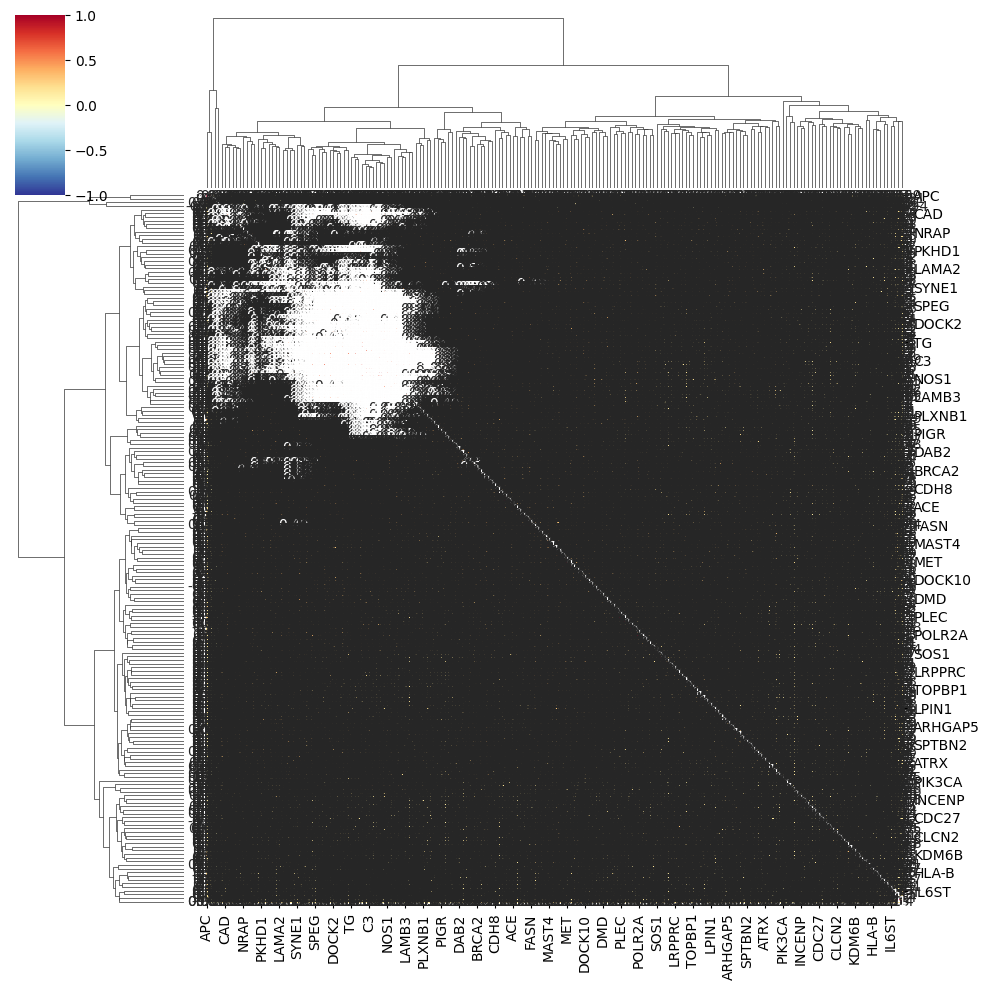

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.clustermap(ccdf.corr(), 
            annot = True,      # 실제 값 화면에 나타내기
            cmap = 'RdYlBu_r',  # Red, Yellow, Blue 색상으로 표시
            vmin = -1, vmax = 1, #컬러차트 -1 ~ 1 범위로 표시
            )

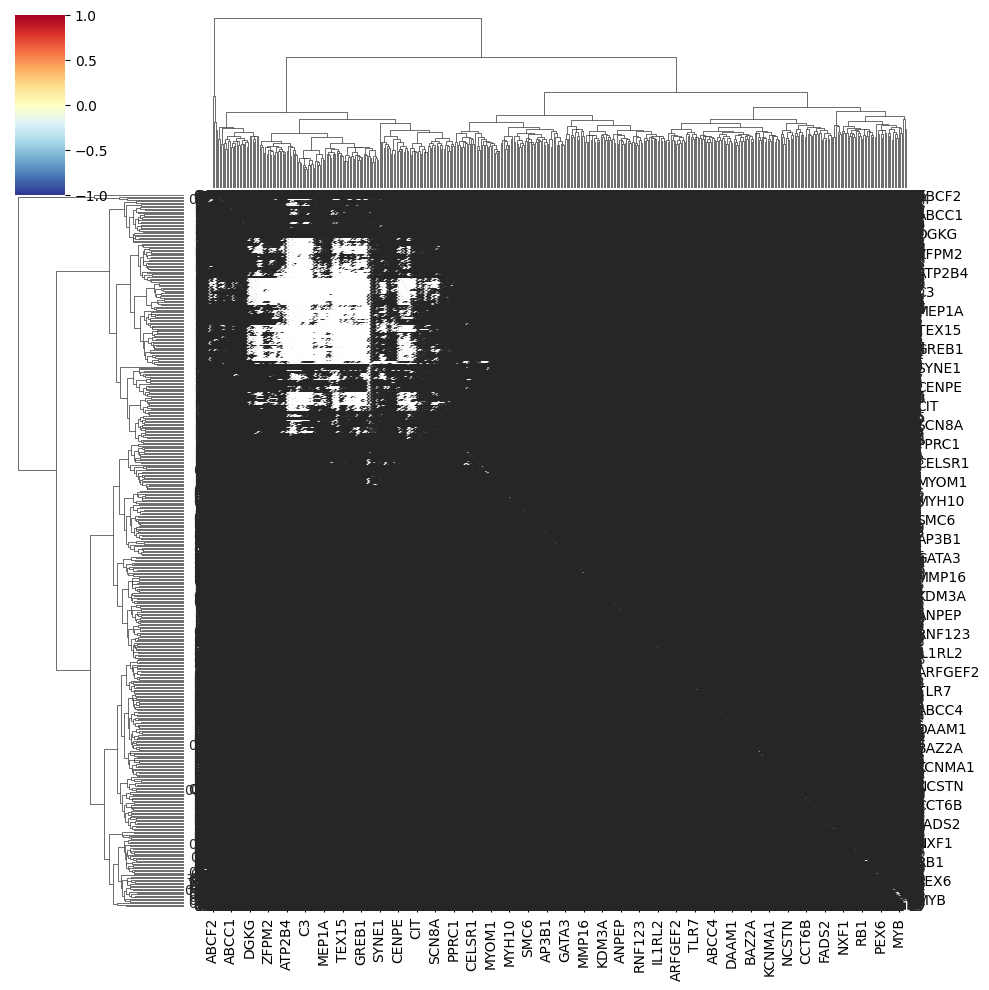

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.clustermap(ccdf.corr(), 
            annot = True,      # 실제 값 화면에 나타내기
            cmap = 'RdYlBu_r',  # Red, Yellow, Blue 색상으로 표시
            vmin = -1, vmax = 1, #컬러차트 -1 ~ 1 범위로 표시
            )

In [27]:
ccdf.TG.argmax

<bound method IndexOpsMixin.argmax of 0       0
1       0
2       0
3       0
4       0
       ..
2541    1
2542    0
2543    1
2544    0
2545    0
Name: TG, Length: 8747, dtype: int64>

In [33]:
max(ccdf.IL6ST)

7

In [9]:
diseaseList = df.SUBCLASS.value_counts().rename_axis('disease').reset_index(name='counts')
diseaseList

,disease,counts
0,BRCA,786
1,KIPAN,515
2,GBMLGG,461
3,STES,379
4,KIRC,334
5,THCA,324
6,SKCM,276
7,PRAD,266
8,OV,253
9,LGG,229


In [10]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
for c in total.columns:
    total[c] = encoder.fit_transform(total[c])



In [11]:
df = total[:6201]
df_test = total[6201:]



In [12]:
df

,ABCB8,AMPH,CAT,RXRG,PIDD1,ISL1,ALS2,STARD4,PDK3,TEX15,...,ITGA5,CUL4A,NLGN3,RRAD,AIFM1,MYH11,HSD17B2,ITGB3,PKHD1,TXNIP
0,93,169,59,93,72,82,163,41,51,320,...,126,93,113,55,69,27,52,123,516,60
1,93,169,59,93,72,82,163,41,51,320,...,126,93,113,55,69,319,52,123,516,60
2,93,169,59,93,72,82,163,41,51,320,...,126,93,113,55,69,319,52,123,516,60
3,93,169,59,93,72,82,163,41,51,320,...,126,93,113,55,69,319,52,123,516,60
4,93,169,59,93,72,82,163,41,51,320,...,126,93,113,55,69,319,52,123,516,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6196,31,169,59,93,72,82,163,41,51,320,...,126,93,113,55,69,319,52,123,516,60
6197,93,169,59,93,72,82,163,41,51,320,...,126,93,113,55,69,319,52,123,516,60
6198,93,169,59,93,72,82,163,41,51,320,...,126,93,113,55,69,319,52,123,516,60
6199,93,169,59,93,72,82,163,41,51,320,...,126,93,113,55,69,319,52,123,516,60


In [13]:
df_test

,ABCB8,AMPH,CAT,RXRG,PIDD1,ISL1,ALS2,STARD4,PDK3,TEX15,...,ITGA5,CUL4A,NLGN3,RRAD,AIFM1,MYH11,HSD17B2,ITGB3,PKHD1,TXNIP
0,93,169,59,93,72,82,163,41,51,320,...,126,93,113,55,69,319,52,123,516,60
1,93,169,61,93,72,82,85,41,51,320,...,126,93,113,55,69,319,52,123,516,60
2,93,169,59,93,72,82,163,41,51,320,...,126,93,113,55,69,319,52,123,516,60
3,93,169,59,93,72,82,163,41,51,320,...,126,93,113,55,69,319,52,123,516,60
4,93,169,59,93,72,82,163,41,51,320,...,126,93,113,55,69,319,52,123,516,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2541,93,169,59,93,72,82,163,41,51,320,...,126,93,113,55,69,319,52,123,490,60
2542,93,169,59,93,72,82,163,41,51,320,...,126,93,113,55,69,56,52,123,516,60
2543,60,157,3,93,72,82,133,41,50,270,...,126,7,113,55,69,187,52,123,43,60
2544,93,169,59,93,72,82,163,41,51,320,...,126,93,113,55,69,319,52,123,516,60


In [14]:
from sklearn.preprocessing import LabelEncoder
X = df
y = df_target
encoder2 = LabelEncoder()
y = encoder2.fit_transform(y)
y


array([ 8, 19, 20, ...,  4, 22, 20])

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=156)
print(X_train.shape, X_test.shape)

(4340, 2576) (1861, 2576)


In [16]:
dtrain = xgb.DMatrix(data = X_train, label= y_train)
dtest = xgb.DMatrix(data = X_test, label = y_test)


#Multi-class classification

In [52]:
params = {
    'tree_method': 'approx',
    'objective': 'multi:softprob',
    'num_class': 26
}
num_boost_round = 10

dtrain = xgb.DMatrix(data = X_train, label= y_train)
dtest = xgb.DMatrix(data = X_test, label = y_test)
model = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_boost_round, #early_stopping_rounds=5, 
                  evals=[(dtrain, 'train'), (dtest, 'valid')],
                  verbose_eval=2)

[0]	train-mlogloss:2.62815	valid-mlogloss:2.71554
[2]	train-mlogloss:2.23955	valid-mlogloss:2.46264
[4]	train-mlogloss:2.01032	valid-mlogloss:2.33915
[6]	train-mlogloss:1.85121	valid-mlogloss:2.26501
[8]	train-mlogloss:1.73240	valid-mlogloss:2.21929
[10]	train-mlogloss:1.64007	valid-mlogloss:2.18845
[12]	train-mlogloss:1.56804	valid-mlogloss:2.16630
[14]	train-mlogloss:1.50729	valid-mlogloss:2.14952
[16]	train-mlogloss:1.45357	valid-mlogloss:2.13840
[18]	train-mlogloss:1.40684	valid-mlogloss:2.13066
[20]	train-mlogloss:1.36576	valid-mlogloss:2.12458
[22]	train-mlogloss:1.32932	valid-mlogloss:2.12065
[24]	train-mlogloss:1.29695	valid-mlogloss:2.12028
[26]	train-mlogloss:1.26616	valid-mlogloss:2.12199
[28]	train-mlogloss:1.23775	valid-mlogloss:2.11884
[30]	train-mlogloss:1.21123	valid-mlogloss:2.11912
[32]	train-mlogloss:1.18626	valid-mlogloss:2.12038
[34]	train-mlogloss:1.16356	valid-mlogloss:2.12054
[36]	train-mlogloss:1.14114	valid-mlogloss:2.12140
[38]	train-mlogloss:1.11951	valid-ml

In [68]:
params = {
    'tree_method': 'approx',
    'objective': 'multi:softprob',
    #'learning_rate': 0.05
}
num_boost_round = 10

clf = xgb.XGBClassifier(n_estimators=num_boost_round,early_stopping_rounds=5, **params)
clf.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_test,y_test)],
        verbose=2);

[0]	validation_0-mlogloss:2.62815	validation_1-mlogloss:2.71554
[2]	validation_0-mlogloss:2.23955	validation_1-mlogloss:2.46264
[4]	validation_0-mlogloss:2.01032	validation_1-mlogloss:2.33915
[6]	validation_0-mlogloss:1.85121	validation_1-mlogloss:2.26501
[8]	validation_0-mlogloss:1.73240	validation_1-mlogloss:2.21929
[10]	validation_0-mlogloss:1.64007	validation_1-mlogloss:2.18845
[12]	validation_0-mlogloss:1.56804	validation_1-mlogloss:2.16630
[14]	validation_0-mlogloss:1.50729	validation_1-mlogloss:2.14952
[16]	validation_0-mlogloss:1.45357	validation_1-mlogloss:2.13840
[18]	validation_0-mlogloss:1.40684	validation_1-mlogloss:2.13066
[20]	validation_0-mlogloss:1.36576	validation_1-mlogloss:2.12458
[22]	validation_0-mlogloss:1.32932	validation_1-mlogloss:2.12065
[24]	validation_0-mlogloss:1.29695	validation_1-mlogloss:2.12028
[26]	validation_0-mlogloss:1.26616	validation_1-mlogloss:2.12199
[28]	validation_0-mlogloss:1.23775	validation_1-mlogloss:2.11884
[30]	validation_0-mlogloss:1.2

In [56]:
y_true = y_test
y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)
y_true.shape, y_pred.shape, y_score.shape

((1861,), (1861,), (1861, 26))

In [57]:
from sklearn import metrics 
metrics.accuracy_score(y_true, y_pred)

0.3476625470177324

In [58]:
from sklearn import metrics 
metrics.accuracy_score(y_true, y_pred)

0.3476625470177324

In [59]:
print(metrics.classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.70      0.82        23
           1       0.45      0.14      0.22        35
           2       0.28      0.66      0.40       238
           3       0.19      0.08      0.11        39
           4       0.61      0.62      0.61        63
           5       1.00      0.06      0.12        16
           6       0.33      0.27      0.30       150
           7       0.30      0.27      0.28        60
           8       0.24      0.33      0.28       159
           9       0.07      0.04      0.05       104
          10       0.83      0.31      0.45        48
          11       0.24      0.37      0.29        57
          12       0.26      0.17      0.20        48
          13       0.28      0.12      0.17        59
          14       0.33      0.10      0.16        49
          15       0.27      0.44      0.34        93
          16       0.27      0.11      0.15        28
          17       0.21    

In [67]:
metrics.roc_auc_score(y_true, y_score, average='weighted', multi_class='ovr')

0.8583267012357305

In [61]:
clf.predict(df_test)

array([21, 25,  2, ..., 25, 10,  6])

In [62]:
res = clf.predict(df_test)



In [ ]:
clf.predict_proba(df_test)#[:,1]

In [63]:
res = encoder2.inverse_transform(res)

In [64]:

df_test1 = pd.read_csv('test.csv')
res_df = pd.DataFrame ({'ID' : df_test1['ID'], 'SUBCLASS' : res})
res_df


,ID,SUBCLASS
0,TEST_0000,STES
1,TEST_0001,UCEC
2,TEST_0002,BRCA
3,TEST_0003,LGG
4,TEST_0004,HNSC
...,...,...
2541,TEST_2541,BLCA
2542,TEST_2542,PAAD
2543,TEST_2543,UCEC
2544,TEST_2544,LAML


In [66]:
res_df.to_csv('res07-2578-6-2.csv',index = False)

In [ ]:
pred_probs = xgb_model.predict(dtest)


In [ ]:
import numpy as np
print(np.round(pred_probs[:10], 3))


In [58]:
preds= [round(x) if x > 0 else 0 for x in pred_probs]

In [ ]:
preds

In [60]:
for p in preds:
    if p<0:
        print(p)


In [ ]:
encoder.inverse_transform(preds)

In [35]:
model = RandomForestClassifier(
            n_estimators=50, ## 붓스트랩 샘플 개수 또는 base_estimator 개수
            criterion='entropy', ## 불순도 측도
            max_depth=65, ## 개별 나무의 최대 깊이
            #max_features='sqrt', ## 매 분리시 랜덤으로 뽑을 변수 개수
            #max_samples=1.0, ## 붓스트랩 샘플 비율 => 1이면 학습데이터를 모두 샘플링한다.
            #bootstrap=True, ## 복원 추출,  False이면 비복원 추출
            oob_score=True, ## Out-of-bag 데이터를 이용한 성능 계산
            random_state=100
).fit(X,y)


In [ ]:
## 예측
print(model.predict(X)[:3]) 
print()


In [ ]:
X[:3]

In [ ]:
## 성능 평가
print(model.oob_score_) ## Out-of-bag 성능 평가 점수
print('정확도 : ', model.score(X,y)) ## 테스트 성능 평가 점수(Accuracy)
print()
## 변수 중요도
print(model.feature_importances_)




In [ ]:
## 성능 평가
print(model.oob_score_) ## Out-of-bag 성능 평가 점수
print('정확도 : ', model.score(X,y)) ## 테스트 성능 평가 점수(Accuracy)
print()
## 변수 중요도
print(model.feature_importances_)




In [ ]:
res = model.predict(df_test)
res

In [ ]:
res = model.predict(df_test)
res

In [ ]:
df_test1 = pd.read_csv('test.csv')
res_df = pd.DataFrame ({'ID' : df_test1['ID'], 'SUBCLASS' : res})
res_df



In [24]:
res_df.to_csv('res04.csv',index = False)

In [ ]:
df[df.SUBCLASS == 'BRCA'].sum().sort_values(ascending=False).str.replace('WT','')

In [ ]:
df[df['SUBCLASS']=='DLBC']

In [ ]:
import numpy as np 
dfs = df[df['SUBCLASS']=='DLBC']
dfs.columns

In [ ]:
for c in dfs.columns:
    dfs[c] = np.where(dfs[c] == 'WT', 0, 1)
dfs

    

In [ ]:
dfs = df[df['SUBCLASS']=='DLBC']
dfs.apply(lambda x: x(if x=='WT' else x=1))

In [ ]:
for  x in df.iloc[0]:
    if x != 'WT': print(x)


In [ ]:
len(df_test.columns)

In [ ]:
len(df_test)

In [ ]:
df.colu